<a href="https://colab.research.google.com/github/natskiu/Nasa-Battery/blob/main/Data_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and feature extraction

In this notebook, we import and process the raw experimental data to extract the required features. We then store these into a Pandas dataframe which can be exported to a csv file for future use.

## Importing libraries and loading data

In [10]:
import numpy as np
import matplotlib.pyplot as plt
#this is a comment
import scipy.io as sio
import pandas as pd
import modules.utils as tools


In [11]:
import importlib
tools = importlib.reload(tools)

In [65]:
# raw=true is important so you download the file rather than the webpage.
#!wget https://github.com/natskiu/Nasa-Battery/blob/main/Data/B0005.mat?raw=true
# rename the file - we are importing the data for one battery, B0005.
#!mv B0005.mat\?raw\=true B0005.mat
# update scipy
#!pip install -U -q scipy
# Load the data
from scipy import io
import os
datapath = 'Data/'
v = io.loadmat(datapath + 'B0056.mat')

## Preprocessing raw data

### Raw data structure 
The raw battery data (defined as v) is a nested dictionary with keys = ['__header__', '__version__', '__globals__', 'B0005']

In [66]:
v.keys()

dict_keys(['__header__', '__version__', '__globals__', 'B0056'])

In [67]:
# This extracts the data for all cycles in the form of a nested numpy array.
raw_cycles = np.vstack(v['B0056'][0,0])
type(raw_cycles)

numpy.ndarray

In [68]:
raw_cycles.shape

(1, 252)

In [69]:
# the middle index indicates the charge/discharge number. 
# For example, cycles[0,0][3] gets the data for the first charge, cycles[0,1][3] gets the data for the first discharge, etc.
raw_cycles[0,0][3].shape

(1, 1)

In [70]:
discharge_indices = tools.get_indices(raw_cycles, is_charge = False)
discharge_indices = discharge_indices
#discharge_indices.remove(8)
#discharge_indices.pop()
print(discharge_indices)
len(discharge_indices)

[0, 4, 6, 8, 10, 12, 16, 18, 20, 22, 24, 28, 30, 32, 34, 36, 40, 42, 44, 46, 48, 52, 56, 58, 60, 62, 64, 68, 70, 72, 74, 76, 80, 82, 84, 86, 88, 92, 94, 96, 98, 100, 104, 108, 110, 112, 114, 116, 120, 122, 124, 126, 128, 132, 134, 136, 138, 140, 144, 146, 148, 150, 152, 156, 158, 160, 162, 164, 168, 172, 174, 176, 178, 180, 184, 186, 188, 190, 192, 196, 198, 200, 202, 204, 208, 210, 212, 214, 216, 220, 224, 226, 228, 230, 232, 236, 238, 240, 242, 244, 248, 250]


102

In [71]:
charge_indices = tools.get_indices(raw_cycles, is_charge=True)
# manually look through the repeated charge cycle
#charge_indices.remove(9)
#charge_indices.remove(41)
print(charge_indices)
len(charge_indices)

[2, 5, 7, 9, 11, 14, 17, 19, 21, 23, 26, 29, 31, 33, 35, 38, 41, 43, 45, 47, 50, 54, 57, 59, 61, 63, 66, 69, 71, 73, 75, 78, 81, 83, 85, 87, 90, 93, 95, 97, 99, 102, 106, 109, 111, 113, 115, 118, 121, 123, 125, 127, 130, 133, 135, 137, 139, 142, 145, 147, 149, 151, 154, 157, 159, 161, 163, 166, 170, 173, 175, 177, 179, 182, 185, 187, 189, 191, 194, 197, 199, 201, 203, 206, 209, 211, 213, 215, 218, 222, 225, 227, 229, 231, 234, 237, 239, 241, 243, 246, 249, 251]


102

In [9]:
"This is how you extract all the features from cycles"
#np.vstack(cycles[0,0][3][0,0])[0]

'This is how you extract all the features from cycles'

In [72]:
new_cycles = tools.capacity_vectorizer(discharge_indices, raw_cycles)

In [73]:
new_cycles.shape

(1, 252)

In [74]:

new_cycles[0,0][3][0,0][6].shape

(280,)

In [301]:
for discharge_index in discharge_indices:
    times = new_cycles[0,discharge_index][3][0,0][5].flatten().tolist()
    print(times[-1], discharge_index)


2349.64 0
2560.688 4
2522.375 6
2488.719 8
2474.844 10
2473.875 12
2495.5 16
2481.078 18
2460.125 20
2440.547 22
2449.922 24
2408.781 28
2442.547 30
2420.671 32
2409.906 34
2416.672 36
2395.75 40
2410.688 42
2402.125 44
2355.265 46
2396.719 48
2442.344 52
2444.703 56
2412.25 58
2403.234 60
2361.047 62
2392.468 64
2373.89 68
2383.234 70
2342.453 72
2359.296 74
2345.453 76
2360.172 80
2315.407 82
2322.156 84
2327.1570000000065 86
2335.0 88
2329.375 92
2333.875 94
2317.453 96
2295.109 98
2326.657 100
2479.297 104
2463.578 108
2458.812 110
2400.672 112
2396.407 114
2392.375 116
2373.687 120
2385.922 122
2345.0 124
2363.047000000006 126
2316.687 128
2322.0 132
2357.687 134


In [302]:
for charge_index in charge_indices:
    times = new_cycles[0,charge_index][3][0,0][5].flatten().tolist()
    print(times[-1], charge_index)


10802.156 2
10806.281 5
10801.937 7
10805.094 9
10803.594 11
10803.532 14
10802.266 17
10802.11 19
10805.265 21
10805.157 23
10805.312 26
10806.578 29
10803.172 31
10803.625 33
10802.39 35
10802.406 38
10802.516 41
10804.938 43
10806.828 45
10804.5 47
10802.858999999997 50
10804.594 54
10806.172000000006 57
10803.406 59
10803.828 61
10803.063 63
10803.437 66
10806.938 69
10804.875 71
10806.891 73
10802.0 75
10803.469 78
10806.938 81
10805.312 83
10804.609 85
10803.234 87
10805.313 90
10806.375 93
10803.187 95
10806.031 97
10807.141 99
10803.141 102
10806.86 106
10807.406 109
10803.157000000007 111
10802.203 113
10803.094 115
10804.547 118
10805.813 121
10808.032 123
10803.219 125
10803.406 127
10802.032 130
10804.016 133
10803.422 135


In [ ]:
tools.cycle_plotter(new_cycles, discharge_indices)

## Functions to extract features from original dataset

### Features
#### Discharging cycle

1. Time taken for discharging temperature to reach max value (set threshold ~ 1000s)
2. Max. temperature during discharge
3. Slope for temperature during discharge 
(max_temp - initial_temp)/(time_at_max_temp)
4. Time for voltage_measured to drop below 3 Volts
5. Slope for first 20 data points of voltage_measured

#### Charging cycle

6. Time  taken for charging temperature to reach max value (set threshold ~ 1000s)
7. Max. temperature during charge

### Label
* Capacity recorded for each discharging cycle


## Data Exploration

In [372]:
import importlib
tools = importlib.reload(tools)

In [75]:
feature_1_list, feature_2_list = tools.extract_feature_1_2_6_7(discharge_indices, new_cycles, l_threshold=10, r_threshold=1200, peak_width=3)
feature_6_list, feature_7_list = tools.extract_feature_1_2_6_7(charge_indices, new_cycles, l_threshold=100, r_threshold=1500)
feature_3_list = tools.extract_feature_3(discharge_indices, new_cycles, l_threshold=10, r_threshold=1200, peak_width=3)
feature_4_list = tools.extract_feature_4(new_cycles, discharge_indices)
feature_5_list = tools.extract_feature_5(new_cycles, discharge_indices)
label_list = tools.extract_label(new_cycles, discharge_indices)
remaining_cycles_list = tools.remaining_cycles(new_cycles, discharge_indices, threshold=0.7)

In [76]:
features_dict = {'time_for_max_temp_D':feature_1_list,'max_temp_D':feature_2_list,
                 'slope_temp_D': feature_3_list, 'time_voltage_measured_below3_D':feature_4_list,
                 'slope_voltage_measured_D':feature_5_list, 'time_for_max_temp_C':feature_6_list,
                 'max_temp_C':feature_7_list, 'capacity': label_list, 'remaining_cycles': remaining_cycles_list}

In [77]:
df = pd.DataFrame(data = features_dict)
df

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
0,262.891,9.910653,0.013760,993.094,-0.000051,115.219,6.403115,0.785278,101
1,942.516,11.741920,0.007010,2101.594,-0.000352,116.890,8.446219,1.344356,100
2,266.344,8.584972,0.008543,2039.578,-0.000659,116.813,5.977690,1.317503,99
3,925.515,11.411268,0.006699,2080.594,-0.000536,103.610,8.528743,1.297365,98
4,374.719,9.150559,0.007930,1996.141,-0.000583,105.094,7.049554,1.263960,97
...,...,...,...,...,...,...,...,...,...
97,328.187,8.905384,0.007373,1828.187,-0.000570,107.250,8.743739,1.130219,4
98,NaN,NaN,NaN,1730.437,-0.000521,107.968,9.308852,1.125872,3
99,470.609,9.601768,0.006927,1799.062,-0.000531,684.313,7.952919,1.143011,2
100,435.406,9.474135,0.007005,1812.281,-0.000524,110.094,8.857151,1.137273,1


In [64]:
filepath = 'processed_csv/'
name = 'B0056_processed.csv'
df.to_csv(filepath+name)

In [78]:
df.describe()

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
count,84.000000,84.000000,84.000000,102.000000,102.000000,99.000000,99.000000,102.000000,102.000000
mean,647.605786,9.873511,0.006109,1868.598775,-0.000517,210.478737,8.161598,1.177000,50.500000
std,307.627618,1.288280,0.002417,128.777064,0.000067,197.950083,0.765902,0.066266,29.588849
min,44.859000,4.564048,-0.010421,993.094000,-0.000659,103.610000,5.977690,0.785278,0.000000
25%,372.816500,9.209036,0.005635,1800.191000,-0.000541,107.515500,7.697284,1.137595,25.250000
50%,686.164000,10.201501,0.006221,1869.734500,-0.000513,115.563000,8.350593,1.174039,50.500000
75%,899.640750,10.749767,0.007012,1938.511750,-0.000497,158.554500,8.655604,1.213981,75.750000
max,1175.125000,11.741920,0.013760,2111.828000,-0.000051,970.828000,9.447414,1.344356,101.000000


In [79]:
corr_matrix = df.corr()
corr_matrix

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
time_for_max_temp_D,1.000000,0.909685,0.041615,0.210207,0.362673,0.102250,-0.068934,0.352937,0.029521
max_temp_D,0.909685,1.000000,0.395650,0.215604,0.494671,-0.044665,-0.049024,0.339640,0.154444
slope_temp_D,0.041615,0.395650,1.000000,-0.053666,0.314340,-0.276371,-0.085148,-0.049817,0.262621
time_voltage_measured_below3_D,0.210207,0.215604,-0.053666,1.000000,-0.281438,-0.035454,0.046299,0.942903,0.455631
slope_voltage_measured_D,0.362673,0.494671,0.314340,-0.281438,1.000000,0.045662,-0.160543,-0.133795,0.234254
time_for_max_temp_C,0.102250,-0.044665,-0.276371,-0.035454,0.045662,1.000000,-0.385116,0.043565,-0.073940
max_temp_C,-0.068934,-0.049024,-0.085148,0.046299,-0.160543,-0.385116,1.000000,-0.005761,-0.298344
capacity,0.352937,0.339640,-0.049817,0.942903,-0.133795,0.043565,-0.005761,1.000000,0.445989
remaining_cycles,0.029521,0.154444,0.262621,0.455631,0.234254,-0.073940,-0.298344,0.445989,1.000000


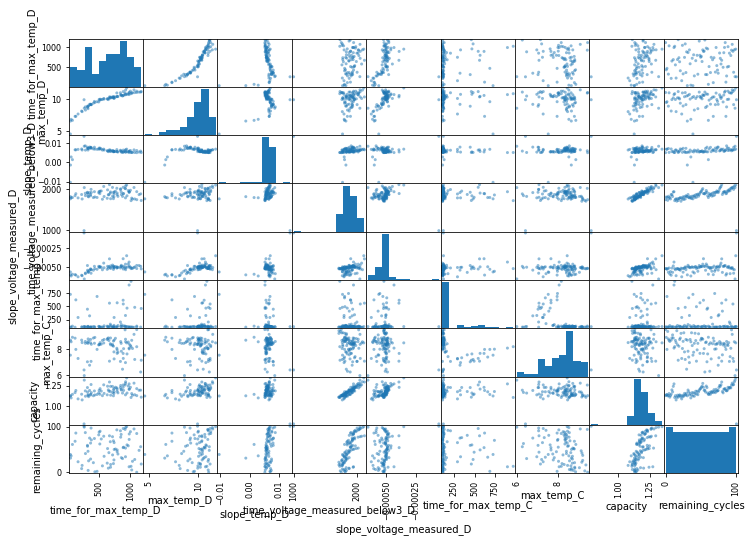

In [80]:
from pandas.plotting import scatter_matrix

attributes = df.columns
scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

In [ ]:
tools.cycle_plotter(new_cycles, discharge_indices)